In [7]:
%load_ext autoreload
%autoreload 2

import os
import socket

cwd = os.getcwd()
hostname = socket.gethostname()

print(f"Host: {hostname}")
print(f"You are here: {cwd}")

from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import
print("Training results should now be reproducible.")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Host: deeplearning-vm
You are here: /home/sebelino7_gmail_com/pycharm_depl
Training results should now be reproducible.


# Train model

Running trial 1/3 for Gradual unfreeze
Running trial 2/3 for Gradual unfreeze
Running trial 3/3 for Gradual unfreeze
Running trial 1/3 for Full unfreeze
Running trial 2/3 for Full unfreeze
Running trial 3/3 for Full unfreeze
Running trial 1/3 for MFT K=10
Running trial 2/3 for MFT K=10
Running trial 3/3 for MFT K=10
Running trial 1/3 for MFT K=100
Running trial 2/3 for MFT K=100
Running trial 3/3 for MFT K=100
Running trial 1/3 for MFT K=1000
Running trial 2/3 for MFT K=1000
Running trial 3/3 for MFT K=1000
Running trial 1/3 for MFT K=4607
Running trial 2/3 for MFT K=4607
Running trial 3/3 for MFT K=4607
Running trial 1/3 for SSL MFT K=100
Running trial 2/3 for SSL MFT K=100
Running trial 3/3 for SSL MFT K=100
Elapsed training time: 111.89808778933366 for Gradual unfreeze
Elapsed training time: 180.86739629800044 for Full unfreeze
Elapsed training time: 113.08779425433265 for MFT K=10
Elapsed training time: 112.61350200400072 for MFT K=100
Elapsed training time: 112.79244017499998 for 

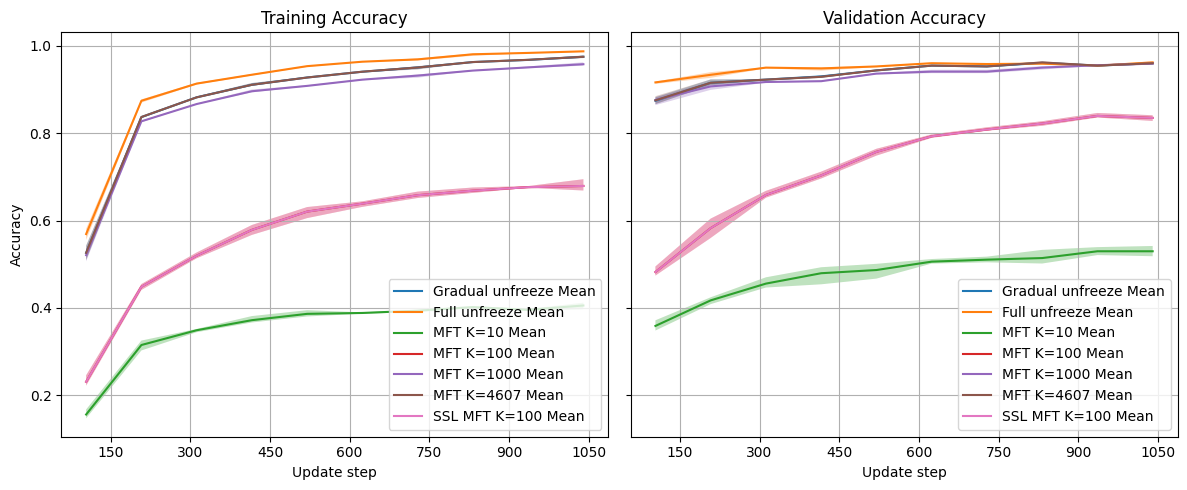

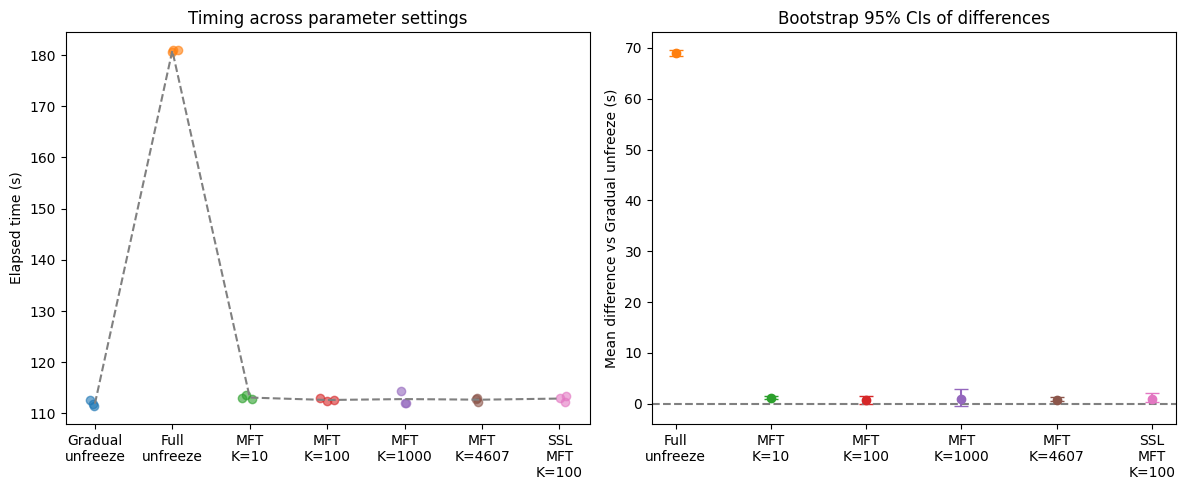

In [8]:
from run import run_multiple
%reload_ext autoreload
%autoreload 2

from typing import Literal
import augmentation
from augmentation import AugmentationParams
from training import TrainParams, NagParams
from freezing import MaskedFineTuningParams
from datasets import DatasetParams
from evaluation import override_param_sets, evaluate_runs_print, evaluate_runs_ci, evaluate_elapsed_time

dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    class_fractions=(1.0,) * 37,
    validation_set_fraction=0.1,
)

architecture: Literal["resnet18", "resnet34", "resnet50"] = "resnet50"
baseline_params = TrainParams(
    seed=determinism.seed,
    architecture=architecture,
    n_epochs=10,
    optimizer=NagParams(
        learning_rate=0.004713842776302303,
        weight_decay=4.287389519996026e-06,
        momentum=0.7222321829989696,
    ),
    freeze_layers=True,
    unfreezing_epochs=(2, 9, 16, 23, 30),
    augmentation=AugmentationParams(
        enabled=True,
        transform=augmentation.to_transform(architecture, ["resize", "flip"]),
        dropout_rate=0.3,
    ),
    mft=MaskedFineTuningParams(
        enabled=False,
        k=100,
        impl="ours",
    ),
    validation_freq=1,
    use_scheduler=True,
    scheduler_type="plateau",
    time_limit_seconds=None,
    val_acc_target=None,
)

overrides = {
    "Gradual unfreeze": dict(mft=dict(enabled=False)),
    "Full unfreeze": dict(freeze_layers=False, unfreezing_epochs=None, unfreeze_last_l_blocks=None),
    "MFT K=10": dict(mft=dict(enabled=True, k=10)),
    "MFT K=100": dict(mft=dict(enabled=True, k=100)),
    "MFT K=1000": dict(mft=dict(enabled=True, k=1000)),
    "MFT K=4607": dict(mft=dict(enabled=True, k=4607)),
}
training_param_sets = override_param_sets(baseline_params, overrides)
results = run_multiple(dataset_params, training_param_sets, determinism, invalidate=False, trials=3)
evaluate_runs_print(results)
evaluate_runs_ci(results)
evaluate_elapsed_time(results, "Gradual unfreeze")



# Test model

In [21]:

from evaluation import evaluate_final_test_accuracy

labelled_data_fractions = [1.0, 0.5]
ssl_params = dict(fixmatch=True, labelled_data_fraction=0.5, pseudo_threshold=0.95, unsup_weight=0.5)

eval_training_params = baseline_params.copy()
eval_training_params.fixmatch = True
eval_training_params.pseudo_threshold = 0.95
eval_training_params.unsup_weight = 0.5

overrides = {
    "No MFT": dict(mft=dict(enabled=False)),
    "MFT K=10": dict(mft=dict(enabled=True, k=10)),
    "MFT K=100": dict(mft=dict(enabled=True, k=100)),
    "MFT K=1000": dict(mft=dict(enabled=True, k=1000)),
    "MFT K=4607": dict(mft=dict(enabled=True, k=4607)),
}
training_param_sets = override_param_sets(eval_training_params, overrides)

for fraction in labelled_data_fractions:
    eval_dataset_params = dataset_params.copy()
    eval_dataset_params.labelled_data_fraction = fraction
    for label, training_param_set in training_param_sets.items():
        if fraction != 1.0:
            label = f"SSL {label}"
        print(f"Evaluating '{label}'")
        evaluate_final_test_accuracy(
            eval_dataset_params,
            training_param_set,
            determinism,
            trials=3,
            display_misclassified=False,
            invalidate=False,
        )

Evaluating 'No MFT'
Test size: 3669
Test Accuracy Mean: 92.66 %
Test Accuracy Standard Error: 0.09 percentage points
Evaluating 'MFT K=10'
Test size: 3669
Test Accuracy Mean: 53.79 %
Test Accuracy Standard Error: 0.42 percentage points
Evaluating 'MFT K=100'
Test size: 3669
Test Accuracy Mean: 83.61 %
Test Accuracy Standard Error: 0.07 percentage points
Evaluating 'MFT K=1000'
Test size: 3669
Test Accuracy Mean: 92.92 %
Test Accuracy Standard Error: 0.10 percentage points
Evaluating 'MFT K=4607'
Test size: 3669
Test Accuracy Mean: 92.66 %
Test Accuracy Standard Error: 0.05 percentage points
Evaluating 'SSL No MFT'
Test size: 3669
Test Accuracy Mean: 92.24 %
Test Accuracy Standard Error: 0.12 percentage points
Evaluating 'SSL MFT K=10'
Test size: 3669
Test Accuracy Mean: 49.52 %
Test Accuracy Standard Error: 0.28 percentage points
Evaluating 'SSL MFT K=100'
Test size: 3669
Test Accuracy Mean: 77.60 %
Test Accuracy Standard Error: 0.15 percentage points
Evaluating 'SSL MFT K=1000'
Test s